# Capstone - Mars Project

## Task 1
- Derive the inertial spacecraft velocity vector $\dot{\bf r} $. Note that for a circular orbit $\dot\theta$ is constant.
- Write a function whose inputs are the radius r and the (3-1-3) Euler angles $(\Omega, i, \theta)$ and the outputs are the inertial position vector $~^{N}{\bf r}$ and velocity $~^{N}{\dot{\bf r}}$  of the associated circular orbit.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

## Initial conditions

In [2]:
R_mars = 3396.19 #km
mu_mars = 42828.3 #km /s

#LMO
h = 400 #km 
r_LMO = R_mars + h
theta_dot_LMO = np.sqrt(mu_mars/r_LMO**3) #rad/sec
t_LMO = 330 #s
angles_LMO = np.array([20,30,60])*np.pi/180 #Ω,i,θ(t_0), in radians
angles_LMO += np.array([0,0, theta_dot_LMO*t_LMO]) #Ω,i,θ(t), in radians

#GMO
r_GMO = 20424.2 #km
theta_dot_GMO = np.sqrt(mu_mars/r_GMO**3) #rad/s
t_GMO = 1150 #s
angles_GMO = np.array([0,0,250])*np.pi/180 #Ω,i,θ(t_0), in radians
angles_GMO += np.array([0,0, theta_dot_GMO*t_GMO]) #Ω,i,θ(t), in radians

#Spacecraft
sigma_BN = np.array([0.3, -0.4, 0.5])
w_BN_B = np.array([1.0, 1.75, -2.2])*np.pi/180
I = np.array([[10,0,0],[0,5,0],[0,0,7.5]])


$\dot{\bf r} = \dot{r} \hat{r} + r\dot\theta\hat\theta$

Since the orbit is circular and $\dot\theta$ is constant:

$\dot{\bf r} = r\dot\theta\hat\theta$

In [3]:
def DCM_from_euler(x, sequence):
    '''
    Generally computes the Direct Cosine Matrix from a set of Euler angles and its rotation sequence
    ----------
    Arguments:
        x {np.array} -- Set of angles, in radians
        sequence {list-like} -> Rotation sequence (for instance, [3,1,3])
    ----------
    Returns:
        (3,3) np.array -- Direct Cosine Matrix
    '''
    
    for e in x:
        while e>2*np.pi:
            e -= 2*np.pi
    DCM_all = []
    
    for i,s in enumerate(sequence):
        if s==3:
            # 3
            DCM_all.append(np.array([[ math.cos(x[i]), math.sin(x[i]),  0],
                   [ -math.sin(x[i]),  math.cos(x[i]), 0],
                   [ 0,  0,  1]]))
        elif s==2:
            # 2
            DCM_all.append(np.array([[ math.cos(x[i]), 0,  -math.sin(x[i])],
                   [ 0, 1, 0],
                   [ math.sin(x[i]),  0,  math.cos(x[i])]]))
        elif s==1:
            # 1
            DCM_all.append(np.array([[ 1, 0,  0],
                   [ 0,  math.cos(x[i]), math.sin(x[i])],
                   [ 0,  -math.sin(x[i]),  math.cos(x[i])]]))
    if len(sequence)!=3:
        print("Error. Sequence does not have a length of 3.")
        return None
    DCM_final = DCM_all[2]@DCM_all[1]@DCM_all[0]
    return DCM_final

In [4]:
def inertial_r_r_dot(r, angles):
    '''
    Takes the norm of the position vector and the set of Euler angles
    and returns the position and velocity vector in the inertial frame
    ----------
    Arguments:
        r {float} -- Norm of the position vector, in km
        angles {np.array} -- Set of angles, in degrees
    ----------
    Returns:
        (2) tuple -- Inertial position vector, Inertial velocity vector
    '''
    mu_mars = 42828.3 #km /s    
    theta_dot = np.sqrt(mu_mars/r**3) #rad/s
    
    NH = DCM_from_euler(angles, [3, 1, 3])
    r_H = np.array([r, 0, 0])
    r_inertial = NH.T@r_H
    
    r_dot = np.array([0, r*theta_dot, 0]) #[r, theta, h], km/s
    r_dot_inertial = NH.T@r_dot
    return r_inertial, r_dot_inertial

## Task 2

Let Hill frame $H = {ı̂_r , ı̂_θ , ı̂_h }$ be the orbit frame of the LMO satellite. These base vectors are generally
defined as
$$ı̂_r = \frac{r_{LMO}}{|r_{LMO} |}$$
$$ı̂_θ = ı̂_h × ı̂_r$$
$$ı̂_h =\frac{
r_{LM} × ṙ_{LMO}}
{|r_{LM} × ṙ_{LMO}|} $$
Your tasks are:
- Determine an analytic expressions for [ HN ]
- Write a function whose input is simply time t , and the output is the DCM [HN (t)]
- Validate the operation of this function by computing $[HN (t = 300 s )]$

In [5]:
def DCM_HN(t):
    '''
    Computes the Direct Cosine Matrix from the Hill Frame (LMO) to the inertial frame (N)
    ----------
    Arguments:
        t {float} -- time from t_0, in seconds
    ----------
    Returns:
        (3,3) np.array -- Direct Cosine Matrix HN
    '''
    # Initial conditions for LMO
    R_mars = 3396.19 #km
    mu_mars = 42828.3 #km /s
    h = 400 #km 
    r_LMO = R_mars + h
    theta_dot_LMO = np.sqrt(mu_mars/r_LMO**3) #rad/sec
    angles_LMO = np.array([20,30,60])*np.pi/180 #Ω,i,θ(t_0), in radians
    angles_LMO += np.array([0,0, theta_dot_LMO*t]) #Ω,i,θ(t), in radians
    
    #Computing inertial vectors
    r_inertial_LMO, r_dot_inertial_LMO = inertial_r_r_dot(r_LMO, angles_LMO)
    
    #Computing Hill Frame versors
    i_r = r_inertial_LMO/np.linalg.norm(r_inertial_LMO)
    i_h = np.cross(r_inertial_LMO, r_dot_inertial_LMO)/np.linalg.norm(\
                            np.cross(r_inertial_LMO, r_dot_inertial_LMO))
    i_theta = np.cross(i_h, i_r)
    HN = np.array([i_r, i_theta, i_h])
    return HN

## Task 3

To point the spacecraft solar panels axis $b̂_3$ at the sun, the reference frame $R_s$ must be chosen such
that $r̂_3$ axis points in the sun direction ( $n̂_2$ in this scenario). Further, assume the first axis $r̂_1$ points in
the $− n̂_1$ direction.

Your tasks are:

Determine an analytic expressions for the sun pointing reference frame Rs by defining the DCM $[RsN]$
Write a function that returns $[RsN]$.

$R_s$ frame:

$^{N}r̂_1 = -n̂_1$

$^{N}r̂_3 = n̂_2$,

$^{N}r̂_2 = ^{N}r̂_3 x ^{N}r̂_1 =  n̂_2 x - n̂_1 = n̂_3$,


In [6]:
def RsN():
    '''
    Returns the Direct Cosine Matrix from the Rs (Sun) frame to the N (Mars) frame
    ----------
    Arguments:
        None
    ----------
    Returns:
        (3,3) np.array -- Direct Cosine Matrix RsN
    
    '''
    r_1 = np.array([-1.,0.,0.])
    r_2 = np.array([0.,0.,1.])
    r_3 = np.array([0.,1.,0.])
    RsN = np.array([r_1, r_2, r_3])
    return RsN

## Task 4

To point the spacecraft sensor platform axis $b̂_1$ towards the center of Mars or nadir direction, the reference frame $R_n$ must be chosen such that $r̂_1$ axis points towards the planet. Further, assume the
second axis $r̂_2$ points in the velocity direction $ı̂_θ$ .

Your tasks are:

- Determine an analytic expressions for the nadir pointing reference frame Rn by defining the DCM $[R_nN]$
- Write a function that returns $[R_nN]$ as a function of time.
- Write a function that determines the angular velocity vector  $^Nω_{R_n/N}$.


$R_n$ frame:

$r̂_1 = -î_r$

$r̂_2 = î_\theta$,

$r̂_3 = r̂_1 x r̂_2 =  -î_r x î_\theta = -î_h$,


In [7]:
def RnN(t):
    '''
    Computes the Direct Cosine Matrix from the Nadir Reference Frame (Rn) to the inertial frame (N)
    ----------
    Arguments:
        t {float} -- time from t_0, in seconds
    ----------
    Returns:
        (3,3) np.array -- Direct Cosine Matrix RnN
    '''
    # Defining the versors from Rn in the Hill Frame (LMO) to construct the DCM [HRn]
    r_1 = np.array([-1,0,0])
    r_2 = np.array([0,1,0])
    r_3 = np.array([0,0,-1])
    DCM_HRn = np.array([r_1, r_2, r_3])
    
    # [RnN] = [RnH][HN]
    RnN = DCM_HRn.T@DCM_HN(t)
    return RnN

In [8]:
def w_RnN(t):
    '''
    Computes the Direct Cosine Matrix from the Nadir Reference Frame (Rn) to the inertial frame (N)
    ----------
    Arguments:
        t {float} -- time from t_0, in seconds
    ----------
    Returns:
        (3,1) np.array -- Angular velocity w_RnN at time t
    '''
    # Initial conditions for LMO
    R_mars = 3396.19 #km
    mu_mars = 42828.3 #km /s
    h = 400 #km 
    r_LMO = R_mars + h
    theta_dot_LMO = np.sqrt(mu_mars/r_LMO**3) #rad/sec   
    
    # w normally would be, in the H frame:
    w_HN_H = np.array([0,0,theta_dot_LMO])
    
    # Now we just compute that in the N frame
    w_HN_N =  DCM_HN(t).T@w_HN_H
    
    # To get w_RnN, we should note that w_RnN = w_RnH + w_HN
    # But we know that w_RnH should be 0, since we H and Rn are practically coaligned
    # Thus:
    w_RnN_N = w_HN_N
    return w_RnN_N

## Task 5

To point the nano-satellite communication platform axis $− b̂_1$ towards the GMO mother spacecraft, the
communication reference frame $R_c$ must be chosen such that $−r̂_1$ axis points towards the GMO satellite
location. Assume $∆r = r_{GMO} − r_{LMO}$ . Further, to fully define a three-dimensional reference frame,
assume the second axis is defined as
$r̂_2 =\frac
{∆r × n̂_3}
{|∆r × n̂_3 |}$
while the third is then defined as $r̂_3 = r̂_1 × r̂_2 $.

Your tasks are:

- Determine an analytic expressions for the communication mode reference frame Rc by defining the DCM $[R_cN]$
- Write a function that returns $[R_cN]$ as a function of time.
- Write a function that determines the angular velocity vector  $^Nω_{R_c/N}$. Note that an analytical expression for this body rate vector is very challenging. It is ok to use numerical differences in these frames to compute $\frac{d}{dt}([R_cN])$, and then relate this to $^Nω_{R_c/N}$. As the orbit trajectories are given as a function of time, it is straight forward to include a time-based numerical difference method.


$R_c$ frame:

$-r̂_1 = î_r => r̂_1 = -\frac{r_{GMO}}{|r_{GMO}|}$

$r̂_2 =\frac
{∆r × n̂_3}
{|∆r × n̂_3 |}$

$r̂_3 = r̂_1 x r̂_2$


In [9]:
def RcN(t):
    '''
    Computes the Direct Cosine Matrix from the GMO-Pointing Reference Frame (Rc) to the inertial frame (N)
    ----------
    Arguments:
        t {float} -- time from t_0, in seconds
    ----------
    Returns:
        (3,3) np.array -- Direct Cosine Matrix RcN
    '''
    R_mars = 3396.19 #km
    mu_mars = 42828.3 #km /s

    #LMO
    h = 400 #km 
    r_LMO = R_mars + h
    theta_dot_LMO = np.sqrt(mu_mars/r_LMO**3) #rad/sec
    angles_LMO = np.array([20,30,60])*np.pi/180 #Ω,i,θ(t_0), in radians
    angles_LMO += np.array([0,0, theta_dot_LMO*t]) #Ω,i,θ(t), in radians

    #GMO
    r_GMO = 20424.2 #km
    theta_dot_GMO = np.sqrt(mu_mars/r_GMO**3) #rad/s
    angles_GMO = np.array([0,0,250])*np.pi/180 #Ω,i,θ(t_0), in radians
    angles_GMO += np.array([0,0, theta_dot_GMO*t]) #Ω,i,θ(t), in radians
    
    # Building delta_r
    r_GMO_inertial, v_GMO_inertial = inertial_r_r_dot(r_GMO, angles_GMO)
    r_LMO_inertial, v_LMO_inertial = inertial_r_r_dot(r_LMO, angles_LMO)
    delta_r = r_GMO_inertial - r_LMO_inertial
    
    #Rc frame
    n_3 = np.array([0,0,1])
    rc_1 = -delta_r/np.linalg.norm(delta_r)
    rc_2 = np.cross(delta_r, n_3)/np.linalg.norm(np.cross(delta_r, n_3))
    rc_3 = np.cross(rc_1, rc_2)
    
    DCM_RcN = np.array([rc_1, rc_2, rc_3])
    return DCM_RcN

In [10]:
def w_RcN(t):
    '''
    Computes the angular velocity from the GMO-Pointing Reference Frame (Rc) to the inertial frame (N)
    ----------
    Arguments:
        t {float} -- time from t_0, in seconds
    ----------
    Returns:
        (3,1) np.array -- Angular velocity w_RcN at time t
    '''
    # d/dt(RcN) = (Rc(t+dt) - Rc(t))/dt
    dt = 0.1
    RcN_dot = (RcN(t+dt) - RcN(t))/dt
    w_tilde = -RcN(t).T@RcN_dot
    w = np.array([-w_tilde[1][2],w_tilde[0][2],-w_tilde[0][1]])
    return w

## Task 6


Any attitude feedback control algorithm requires the ability to compute the attitude and angular velocity
tracking errors of the current body frame B relative to the reference frame R . Your tasks are:

Write a function that has the inputs of time, the current body attitude states $σ_{B/N}$ and  $^Bω_{B/N}$, as well as the current references frame frame orientation $[RN]$ and rates  $^Nω_{R/N}$, and returns the associated tracking errors $σ_{B/R}$ and  $^Bω_{B/R}$.

$f(t, \sigma_{BN}, ^B\omega_{BN}, [RN], ^N\omega_{RN})$

In [11]:
def dcm_to_euler_params(BN):
    '''
    Computes the set of Quaternions from a Direct Cosine Matrix
    ----------
    Arguments:
        DCM {np.array} -- Direct Cosine Matrix
    ----------
    Returns:
        (4,1) np.array -- Quaternions
    '''
    tr = BN[1][1]+BN[2][2]+BN[0][0]
    beta0quad = 1/4*(1+tr)
    beta1quad = 1/4*(1+2*BN[0][0]-tr)
    beta2quad = 1/4*(1+2*BN[1][1]-tr)
    beta3quad = 1/4*(1+2*BN[2][2]-tr)
    betaquad = np.array([beta0quad, beta1quad, beta2quad, beta3quad])
    beta = np.zeros(4)
    beta[betaquad.argmax()] = np.sqrt(betaquad.max())
    if betaquad.argmax() == 0:
        beta[1] = 1/4*(BN[1][2]-BN[2][1])/beta[0]
        beta[2] = 1/4*(BN[2][0]-BN[0][2])/beta[0]
        beta[3] = 1/4*(BN[0][1]-BN[1][0])/beta[0]
    elif betaquad.argmax() == 1:
        beta[0] = 1/4*(BN[1][2]-BN[2][1])/beta[1]
        beta[2] = 1/4*(BN[0][1]+BN[1][0])/beta[1]
        beta[3] = 1/4*(BN[2][0]+BN[0][2])/beta[1]
    elif betaquad.argmax() == 2:
        beta[0] = 1/4*(BN[2][0]-BN[0][2])/beta[2]
        beta[1] = 1/4*(BN[0][1]+BN[1][0])/beta[2]
        beta[3] = 1/4*(BN[1][2]+BN[2][1])/beta[2]
    elif betaquad.argmax() == 3:
        beta[0] = 1/4*(BN[0][1]-BN[1][0])/beta[3]   
        beta[1] = 1/4*(BN[2][0]+BN[0][2])/beta[3]
        beta[2] = 1/4*(BN[1][2]+BN[2][1])/beta[3]
    if beta[0]<0:
        beta = -beta
    return beta

In [12]:
def euler_params_to_sigma(beta):
    '''
    Computes the set of Modified Rodrigues Parameters from a set of Quaternions
    ----------
    Arguments:
        beta {np.array} -- Quaternion with dimension 4
    ----------
    Returns:
        (3,1) np.array -- MRP
    '''
    sigma = np.zeros(3)
    for i in range(3):
        if abs((1+beta[0]))<1e-4:
            print(f'(1 + beta[0]) = {(1+beta[0])} in denominator of cell 54')
            sigma[i] = 0
        else:
            sigma[i] = beta[i+1]/(1+beta[0])
    return np.array(sigma)

In [13]:
def tilde(sigma):
    '''
    Computes the tilde matrix com a given vector
    ---------
    Arguments:
        sigma {np.array} -- general vector of dimension 3
    ---------
    Returns:
        (3,3) np.array -- tilde matrix
    '''
    sigma = np.squeeze(sigma)
    return np.array([[0, -sigma[2],sigma[1]],
                     [sigma[2], 0, -sigma[0]],
                     [-sigma[1], sigma[0], 0]
                     ])

In [14]:
def sigma_to_dcm(sigma):
    '''
    Computes the Direct Cosine Matrix from a set of Modified Rodrigues Parameters
    ----------
    Arguments:
        sigma {np.array} -- MRP
    ----------
    Returns:
        (3,3) np.array -- Direct Cosine Matrix
    '''
    sigma_squared = np.inner(sigma, sigma)
    DCM = np.eye(3) + (8*tilde(sigma)@tilde(sigma) - 4*(1 - sigma_squared)*tilde(sigma) )/ (1 + sigma_squared)**2
    return DCM

In [15]:
def dcm_to_sigma(matrix):
    '''
    Computes the set of Modified Rodrigues Parameters from a Direct Cosine Matrix
    ----------
    Arguments:
        (3,3) np.array -- Direct Cosine Matrix
    ----------
    Returns:
        sigma {np.array} -- MRP
    '''
    zeta = np.sqrt(np.trace(matrix) + 1)
    constant = 1 / (zeta**2 + 2 * zeta)
    s1 = constant * (matrix[1, 2] - matrix[2, 1])
    s2 = constant * (matrix[2, 0] - matrix[0, 2])
    s3 = constant * (matrix[0, 1] - matrix[1, 0])
    return np.array([s1, s2, s3])

In [16]:
def tracking(t, sigma_BN, w_BN_B, RN, w_RN_N, mode='other'):
    '''
    Computes the Modified Rodrigues Parameters and the angular velocity
    differences from the reference values (R) to the inertial frame (N) at time t
    ----------
    Arguments:
        t {float} -- time from t_0, in seconds
        sigma_BN {np.array} -- MRP of body relative to inertial frame
        w_BN_B {np.array} -- angular velocity of body relative to inertial frame, in the body frame
        RN {np.array} -- DCM from R to N frame
        w_RN_N {np.array} -- angular velocity of reference relative to inertial frame, in the inertial frame
    ----------
    Returns:
        (2) tuple -- MRP sigma_BR at time t, Angular velocity w_BR_B at time t
    '''
    
    global sigma_BR
    
    #Computing w_BR_B
    BN = sigma_to_dcm(sigma_BN)
    w_RN_B = BN@w_RN_N
    w_BR_B = w_BN_B - w_RN_B
    
    #Computing sigma_BR
    
    if mode=='quaternions':
        BN = sigma_to_dcm(sigma_BN)
        beta_BN = dcm_to_euler_params(BN)
        beta_NR = dcm_to_euler_params(RN.T)
        # In order to sum euler parameters, we can maintain the matrixes and multiply or use the associated matrix below
        #BR = BN@RN.T
        #beta_BR = dcm_to_euler_params(BR)
        BN_associated = np.array([[beta_BN[0], -beta_BN[1], -beta_BN[2], -beta_BN[3]],
                         [beta_BN[1], beta_BN[0], beta_BN[3], -beta_BN[2]],
                         [beta_BN[2], -beta_BN[3], beta_BN[0], beta_BN[1]],
                         [beta_BN[3], beta_BN[2], -beta_BN[1], beta_BN[0]]
                         ])
        beta_BR = BN_associated@beta_NR
        if (1 + beta_BR[0]) > 1e-4:
            sigma_BR = euler_params_to_sigma(beta_BR)

    else:
        BR = BN@RN.T
        beta_BR = dcm_to_euler_params(BR)
        sigma_BR = euler_params_to_sigma(beta_BR)
        #sigma_NR = dcm_to_sigma(RN.T)
        #sigma_BR = sigma_BN + sigma_NR
    
    # Testing for the shadow set
    if np.linalg.norm(sigma_BR) > 1:
        norm = np.linalg.norm(sigma_BR)**2
        sigma_BR = np.array([-i / norm for i in sigma_BR])
    
    return sigma_BR, w_BR_B

## Task 7

In order to integrate the attitude you need a numerical integrator. The LMO and GMO orbit satellite
positions are given already as a function of time from your earlier tasks. Let the propagated attitude
state X be $X =
[σ_ {B/N},
^B ω_
{B/N}]$
Assume that the spacecraft is rigid and its dynamics obey
$[I] ω̇ _{B/N} = −[ \tilde{\omega}_{B/N }][I]ω _{B/N }+ u$
where u is your external control torque vector.

• Write an RK4 integrator using your programing language of choice (i.e., do not use a built-in
integrator such as Matlab’s ode45). Make sure your time step is chosen small enough such that
numerical integrator errors are not visible in your simulation result plots. With RK4 it is ok to use
a fixed integration time step of 1 second. Further, hold the control u vector piece-wise constant
over the RK4 integration to the next time step. You can updated the control u at every time step
in advance fo the RK4 integration step.

• Demonstrate that your integrator works properly by integrating X forward for 500 seconds with
$u = 0$. Provide $H = [I]ω _{B/N}$ at 500s and express the H vector in the B frame.

• Provide the rotational kinetic energy $T = \frac{1}{2} ω_{ B/N}^T
[I]ω _{B/N}$ at 500 seconds.

• Provide the MRP attitude $σ _{B/N} (500s)$

• Provide angular momentum vector $[N H](500s)$ in inertial frame components.

• If you apply a fixed control torque $^B u = (0.01, −0.01, 0.02) Nm$, provide the attitude $σ_{B/N} (t =
100s)$ .

$^B u = −Kσ_{B/R} − P ^B ω_{B/R}$

In [17]:
def control(t, sigma_BN, w_BN_B, task=7):
    global u_B
    K = 0.005555555555555555
    P = 0.16666666666666666
    if t%1==0:
        if task==7:
            K = np.zeros((3,3))
            P = np.zeros((3,3))
            u_B = -K@sigma_BN - P@w_BN_B
        elif task==7.5:
            u_B = np.array([0.01,-0.01,0.02])
        elif task==8:
            sigma_BRs, w_BRs_B = tracking(t, sigma_BN, w_BN_B, RsN(), np.array([0,0,0]))
            u_B = -K*sigma_BRs - P*w_BRs_B
        elif task==9:
            sigma_BRn, w_BRn_B = tracking(t, sigma_BN, w_BN_B, RnN(t), w_RnN(t))
            u_B = -K*sigma_BRn - P*w_BRn_B
        elif task==10:
            sigma_BRc, w_BRc_B = tracking(t, sigma_BN, w_BN_B, RcN(t), w_RcN(t))
            u_B = -K*sigma_BRc - P*w_BRc_B
    return u_B

In [18]:
def wdot(sigma, w, u, L=0):
    '''
    Computes the time derivative of the angular velocity
    ----------
    Arguments:
        sigma {np.array} -- MRP
        w {np.array} -- angular velocity
        L=0 {np.array} -- External torque
    ----------
    Returns:
        (3,1) np.array -- w_dot
    '''
    I = np.array([[10,0,0],[0,5,0],[0,0,7.5]])
    #u = control(sigma, w, task)
    # I w_dot = -w X I w + Q
    w_dot = np.dot(np.linalg.inv(I), (-np.cross(w, np.dot(I, w)) + u + L))
    return w_dot

In [19]:
def sigma_dot(sigma, w):
    '''
    Computes the time derivative of the MRP
    ----------
    Arguments:
        sigma {np.array} -- MRP
        w {np.array} -- angular velocity
    ----------
    Returns:
        (3,1) np.array -- sigma_dot
    '''
    B = 0.25 * np.dot(((1 - np.dot(sigma, sigma)) * np.eye(3) + 2 * tilde(sigma) + 2 * np.outer(sigma,  sigma)), w)
    return B

In [20]:
def X_dot(t, X, task=7):
    '''
    Returns the derivative of the state vector X
    ----------
    Arguments:
        t {float} -- time, in seconds
        X {np.array} -- state vector=(sigma, omega)
    ----------
    Returns:
        (6,1) np.array -- (sigma_dot, omega_dot)
    '''
    
    # Testing for the shadow set
    if np.linalg.norm(X[:3]) > 1:
        norm = np.linalg.norm(X[:3])**2
        X[:3] = np.array([-i / norm for i in X[:3]])
       
    u = control(t, X[:3], X[3:], task)
    w_BN_B_dot = wdot(X[:3], X[3:], u)
    sigma_BN_dot = sigma_dot(X[:3], X[3:])
    return np.concatenate((sigma_BN_dot, w_BN_B_dot), axis=None)

In [21]:
def RK4(f, x0, t0, tf, dt):
    # Time vector
    t = np.arange(t0, tf, dt)
    nt = t.size
    
    # Constructing final vector
    nx = x0.size
    x = np.zeros((nx, nt))
    
    # Initial conditions
    x[:,0] = x0
    
    for k in range(nt-1):
        # At the kth time step, each parameter k_n is computed
        k1 = dt*f(t[k], x[:, k])
        k2 = dt*f(t[k] + dt/2, x[:, k] + k1/2)
        k3 = dt*f(t[k] + dt/2, x[:, k] + k2/2)
        k4 = dt*f(t[k] + dt, x[:, k] + k3)
        
        # k_ns are used to calculate dx
        dx = (k1 + 2*k2 + 2* k3 + k4)/6
        
        #dx is used to calculate x at the next time step
        x[:, k+1] = x[:, k] + dx
        
        
    return x, t

In [22]:
f = lambda t, X: X_dot(t, X)

x0 = np.concatenate((sigma_BN, w_BN_B))
t0 = 0
tf = 500
dt = 1

x, t = RK4(f, x0, t0, tf, dt)

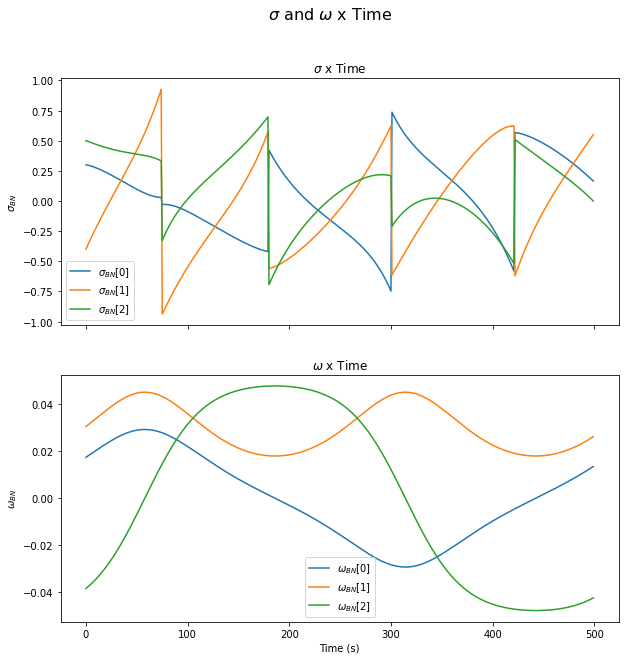

In [23]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.plot(t, x[0][:], label='$\sigma_{BN}$[0]')
ax1.plot(t, x[1][:], label='$\sigma_{BN}$[1]')
ax1.plot(t, x[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.plot(t, x[3][:], label='$\omega_{BN}$[0]')
ax2.plot(t, x[4][:], label='$\omega_{BN}$[1]')
ax2.plot(t, x[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()


In [24]:
w = np.zeros(3)
for wi in range(len(x[3:])):
    w[wi] = x[3:][wi][-1]
H = I@w
print('H_B:', H)

T = 1/2*w.T@I@w
T
print('T:', T)

sigma = np.zeros(3)
for wi in range(len(x[:3])):
    sigma[wi] = x[:3][wi][-1]
    
print('sigma_BN(500s):', sigma)
#sigma = np.array([0.13773779, 0.56014849, -0.0320793])
#H = np.array([0.13761746, 0.13251673, -0.31657046])

BN = sigma_to_dcm(sigma)
H_N = BN@H
print('H_N:', H_N)

H_B: [ 0.13510634  0.13121838 -0.31818881]
T: 0.009384120387989947
sigma_BN(500s): [ 0.16576826  0.55008858 -0.0007551 ]
H_N: [0.26949359 0.0914818  0.23605166]


### Task 7.5

In [25]:
f_new = lambda t, X_new: X_dot(t, X_new, task=7.5)

x0_new = np.concatenate((sigma_BN, w_BN_B))
t0_new = 0
tf_new = 100
dt = 0.1

x_new, t_new = RK4(f_new, x0_new, t0_new, tf_new, dt)

In [26]:
sigma_new = np.zeros(3)
for wi in range(len(x_new[:3])):
    sigma_new[wi] = x_new[:3][wi][-1]
    
print('sigma_BN(100s):', sigma_new)

sigma_BN(100s): [-0.23541146 -0.64069502  0.23968579]


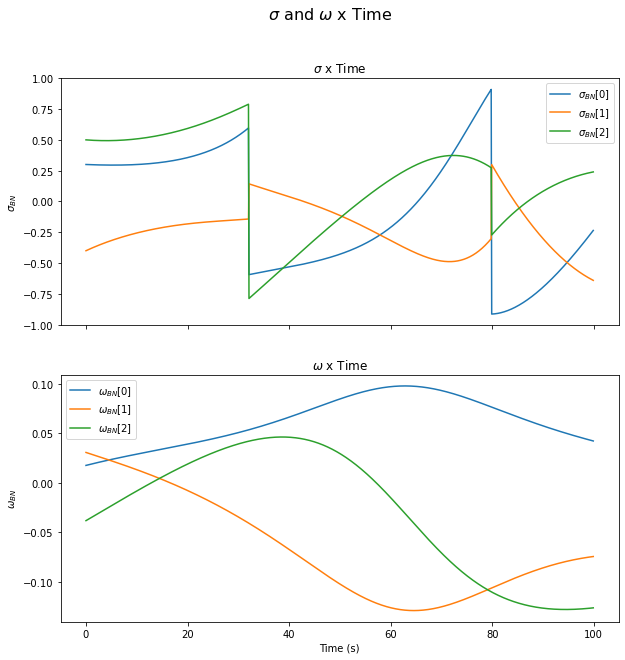

In [27]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.plot(t_new, x_new[0][:], label='$\sigma_{BN}$[0]')
ax1.plot(t_new, x_new[1][:], label='$\sigma_{BN}$[1]')
ax1.plot(t_new, x_new[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.plot(t_new, x_new[3][:], label='$\omega_{BN}$[0]')
ax2.plot(t_new, x_new[4][:], label='$\omega_{BN}$[1]')
ax2.plot(t_new, x_new[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

## Task 8


First the individual control pointing modes are developed and tested on their own. Next they are com-
bined into a full mission scenario simulation in section 4.11. In the current task, use the initial spacecraft
attitude and orbit conditions in section 3.1 and Table 2 and assume the spacecraft is to engage directly
into a sun-pointing mode starting at t0 . The attitude control law is the simple PD control shown in
Eq. (4). Your tasks are:

• Numerically implement this control law in your earlier simulation and ensure that sun-pointing is
achieved with the desired closed loop performance.

• Use linearized closed loop dynamics of a regular problem, such as this sun pointing control, to
determine the K and P feedback gains such that the slowest decay response time (i.e. time for
tracking errors to be 1/e the original size) is 120 seconds. This means all decay time constants
should be 120 seconds or less. Further, the closed loop response for all σB/N components
should be either critically damped or under-damped. Thus at least must be critically damped with
ξ = 1, while the other modes will have ξ ≤ 1.

• Validate the response by providing the σB/N states at t = 15s, 100s, 200s and 400s. Note that
you must always provide the MRP corresponding to the short rotation.


In [28]:
def evaluate_gains():
    '''
    This piece of code computes every possible xi and T for the conditions given (T=120s and and xi=1)
    The Ps are iterated over together with the Ks, giving us three xi and T for each pair
    We then choose the P and K that yield every xi below 1 and every T below 120s
    '''
    
    P_sample = np.array([10/60, 5/60, 7.5/60]) #guarantees at least one T=120s

    I_principal = np.array([10,5,7.5])
    K_sample = []

    for j in range(3):
        #xi[i] = P/np.sqrt(K*I[i])
        K_sample.append([P_sample[j]**2/I_principal[i] for i in range(3)]) #guarantees xi=1

    K_sample = np.array(K_sample).reshape(9,)


    for i in range(len(P_sample)):
        for j in range(len(K_sample)):
            xi = []
            T = []
            for k in range(len(I_principal)):
                xi.append(P_sample[i]/np.sqrt(K_sample[j]*I_principal[k]))
                T.append(2*I_principal[k]/P_sample[i])
                print('INITIAL CONDITIONS: I =', I_principal[k], 'K =', K_sample[j], 'P =', P_sample[i])
            print('T:', T)
            print('xi:', xi)
            print('='*10)
        print('='*40)

In [29]:
f_Rs = lambda t, X_Rs: X_dot(t, X_Rs, task=8)

x0_Rs = np.concatenate((sigma_BN, w_BN_B))
t0_Rs = 0
tf_Rs = 400
dt = 0.1

x_Rs, t_Rs = RK4(f_Rs, x0_Rs, t0_Rs, tf_Rs+dt, dt)

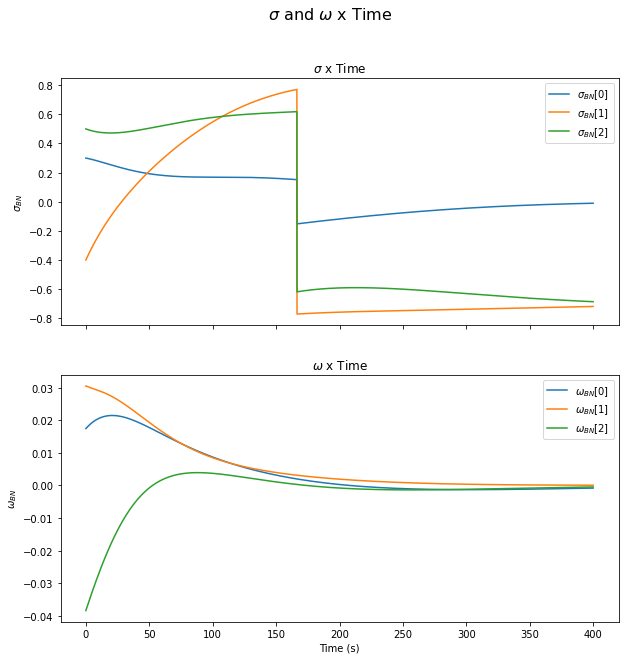

In [30]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.plot(t_Rs, x_Rs[0][:], label='$\sigma_{BN}$[0]')
ax1.plot(t_Rs, x_Rs[1][:], label='$\sigma_{BN}$[1]')
ax1.plot(t_Rs, x_Rs[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.plot(t_Rs, x_Rs[3][:], label='$\omega_{BN}$[0]')
ax2.plot(t_Rs, x_Rs[4][:], label='$\omega_{BN}$[1]')
ax2.plot(t_Rs, x_Rs[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [31]:
t = 15
sigma_Rs_t = np.zeros(3)
for wi in range(len(x_Rs[:3])):
    sigma_Rs_t[wi] = x_Rs[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rs_t)

with open('task8.2.txt', 'w') as first:
    list_sigma_Rs_t = list(sigma_Rs_t)
    first.write(str(list_sigma_Rs_t[0])+' '+str(list_sigma_Rs_t[1])+' '+str(list_sigma_Rs_t[2]))
    
t = 100
sigma_Rs_t = np.zeros(3)
for wi in range(len(x_Rs[:3])):
    sigma_Rs_t[wi] = x_Rs[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rs_t)

with open('task8.3.txt', 'w') as first:
    list_sigma_Rs_t = list(sigma_Rs_t)
    first.write(str(list_sigma_Rs_t[0])+' '+str(list_sigma_Rs_t[1])+' '+str(list_sigma_Rs_t[2]))
    
t = 200
sigma_Rs_t = np.zeros(3)
for wi in range(len(x_Rs[:3])):
    sigma_Rs_t[wi] = x_Rs[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rs_t)

with open('task8.4.txt', 'w') as first:
    list_sigma_Rs_t = list(sigma_Rs_t)
    first.write(str(list_sigma_Rs_t[0])+' '+str(list_sigma_Rs_t[1])+' '+str(list_sigma_Rs_t[2]))
    
t = 400
sigma_Rs_t = np.zeros(3)
for wi in range(len(x_Rs[:3])):
    sigma_Rs_t[wi] = x_Rs[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rs_t)

with open('task8.5.txt', 'w') as first:
    list_sigma_Rs_t = list(sigma_Rs_t)
    first.write(str(list_sigma_Rs_t[0])+' '+str(list_sigma_Rs_t[1])+' '+str(list_sigma_Rs_t[2]))

sigma_BN(15s): [ 0.26559461 -0.15982421  0.47331693]
sigma_BN(100s): [0.16879131 0.54822701 0.57878748]
sigma_BN(200s): [-0.1182327  -0.75781563 -0.59154336]
sigma_BN(400s): [-0.01012719 -0.71883694 -0.68606249]


## Task 9

In [32]:
f_Rn = lambda t, X_Rn: X_dot(t, X_Rn, task=9)

x0_Rn = np.concatenate((sigma_BN, w_BN_B))
t0_Rn = 0
tf_Rn = 400
dt = 0.1

x_Rn, t_Rn = RK4(f_Rn, x0_Rn, t0_Rn, tf_Rn+dt, dt)

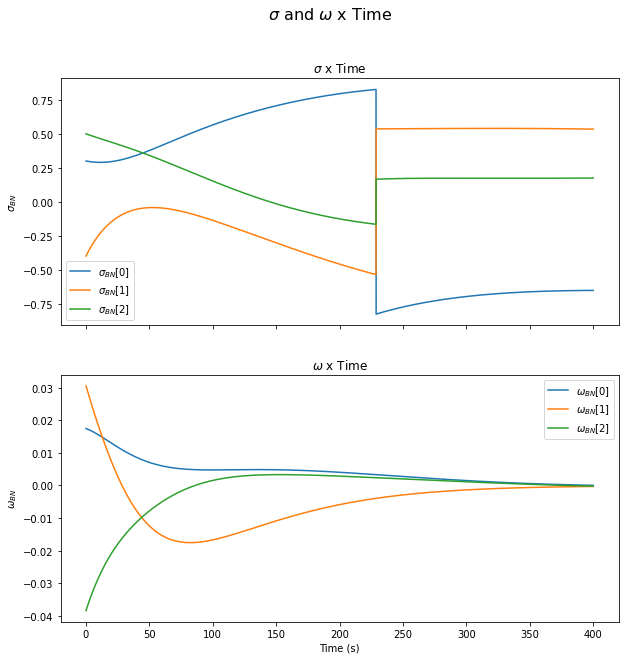

In [33]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.plot(t_Rn, x_Rn[0][:], label='$\sigma_{BN}$[0]')
ax1.plot(t_Rn, x_Rn[1][:], label='$\sigma_{BN}$[1]')
ax1.plot(t_Rn, x_Rn[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.plot(t_Rn, x_Rn[3][:], label='$\omega_{BN}$[0]')
ax2.plot(t_Rn, x_Rn[4][:], label='$\omega_{BN}$[1]')
ax2.plot(t_Rn, x_Rn[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [34]:
t = 15
sigma_Rn_t = np.zeros(3)
for wi in range(len(x_Rn[:3])):
    sigma_Rn_t[wi] = x_Rn[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rn_t)

with open('task9.1.txt', 'w') as fiRnt:
    list_sigma_Rn_t = list(sigma_Rn_t)
    fiRnt.write(str(list_sigma_Rn_t[0])+' '+str(list_sigma_Rn_t[1])+' '+str(list_sigma_Rn_t[2]))
    
t = 100
sigma_Rn_t = np.zeros(3)
for wi in range(len(x_Rn[:3])):
    sigma_Rn_t[wi] = x_Rn[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rn_t)

with open('task9.2.txt', 'w') as fiRnt:
    list_sigma_Rn_t = list(sigma_Rn_t)
    fiRnt.write(str(list_sigma_Rn_t[0])+' '+str(list_sigma_Rn_t[1])+' '+str(list_sigma_Rn_t[2]))
    
t = 200
sigma_Rn_t = np.zeros(3)
for wi in range(len(x_Rn[:3])):
    sigma_Rn_t[wi] = x_Rn[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rn_t)

with open('task9.3.txt', 'w') as fiRnt:
    list_sigma_Rn_t = list(sigma_Rn_t)
    fiRnt.write(str(list_sigma_Rn_t[0])+' '+str(list_sigma_Rn_t[1])+' '+str(list_sigma_Rn_t[2]))
    
t = 400
sigma_Rn_t = np.zeros(3)
for wi in range(len(x_Rn[:3])):
    sigma_Rn_t[wi] = x_Rn[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rn_t)

with open('task9.4.txt', 'w') as fiRnt:
    list_sigma_Rn_t = list(sigma_Rn_t)
    fiRnt.write(str(list_sigma_Rn_t[0])+' '+str(list_sigma_Rn_t[1])+' '+str(list_sigma_Rn_t[2]))

sigma_BN(15s): [ 0.29107122 -0.19122519  0.45350703]
sigma_BN(100s): [ 0.56609163 -0.13729815  0.15222513]
sigma_BN(200s): [ 0.79578935 -0.45968407 -0.12651628]
sigma_BN(400s): [-0.6528482   0.53487286  0.17461082]


## Task 10

In [35]:
f_Rc = lambda t, X_Rc: X_dot(t, X_Rc, task=10)

x0_Rc = np.concatenate((sigma_BN, w_BN_B))
t0_Rc = 0
tf_Rc = 400
dt = 0.1

x_Rc, t_Rc = RK4(f_Rc, x0_Rc, t0_Rc, tf_Rc+dt, dt)

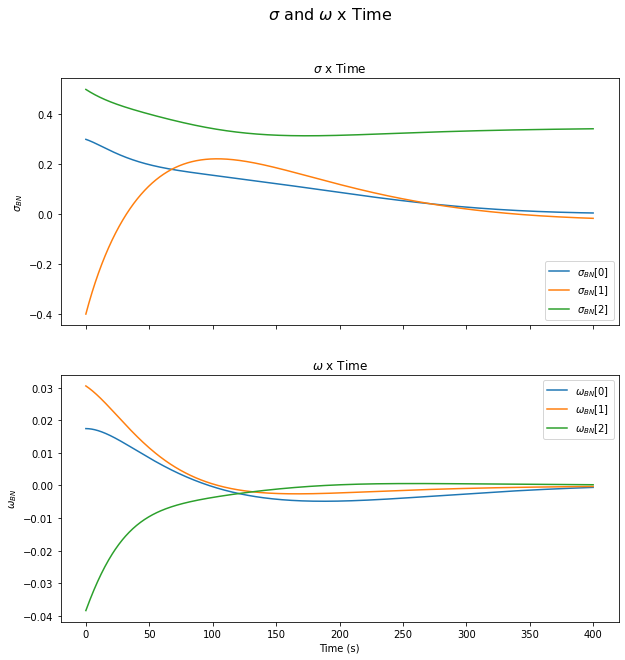

In [36]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.plot(t_Rc, x_Rc[0][:], label='$\sigma_{BN}$[0]')
ax1.plot(t_Rc, x_Rc[1][:], label='$\sigma_{BN}$[1]')
ax1.plot(t_Rc, x_Rc[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.plot(t_Rc, x_Rc[3][:], label='$\omega_{BN}$[0]')
ax2.plot(t_Rc, x_Rc[4][:], label='$\omega_{BN}$[1]')
ax2.plot(t_Rc, x_Rc[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [37]:
t = 15
sigma_Rc_t = np.zeros(3)
for wi in range(len(x_Rc[:3])):
    sigma_Rc_t[wi] = x_Rc[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rc_t)

with open('task10.1.txt', 'w') as fiRct:
    list_sigma_Rc_t = list(sigma_Rc_t)
    fiRct.write(str(list_sigma_Rc_t[0])+' '+str(list_sigma_Rc_t[1])+' '+str(list_sigma_Rc_t[2]))
    
t = 100
sigma_Rc_t = np.zeros(3)
for wi in range(len(x_Rc[:3])):
    sigma_Rc_t[wi] = x_Rc[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rc_t)

with open('task10.2.txt', 'w') as fiRct:
    list_sigma_Rc_t = list(sigma_Rc_t)
    fiRct.write(str(list_sigma_Rc_t[0])+' '+str(list_sigma_Rc_t[1])+' '+str(list_sigma_Rc_t[2]))
    
t = 200
sigma_Rc_t = np.zeros(3)
for wi in range(len(x_Rc[:3])):
    sigma_Rc_t[wi] = x_Rc[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rc_t)

with open('task10.3.txt', 'w') as fiRct:
    list_sigma_Rc_t = list(sigma_Rc_t)
    fiRct.write(str(list_sigma_Rc_t[0])+' '+str(list_sigma_Rc_t[1])+' '+str(list_sigma_Rc_t[2]))
    
t = 400
sigma_Rc_t = np.zeros(3)
for wi in range(len(x_Rc[:3])):
    sigma_Rc_t[wi] = x_Rc[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rc_t)

with open('task10.4.txt', 'w') as fiRct:
    list_sigma_Rc_t = list(sigma_Rc_t)
    fiRct.write(str(list_sigma_Rc_t[0])+' '+str(list_sigma_Rc_t[1])+' '+str(list_sigma_Rc_t[2]))

sigma_BN(15s): [ 0.26543804 -0.16878399  0.45948446]
sigma_BN(100s): [0.15613891 0.22167733 0.34312546]
sigma_BN(200s): [0.087283   0.1194033  0.31615782]
sigma_BN(400s): [ 0.00497672 -0.01647214  0.34238458]


## Task 11

Finally you are ready to simulate the full on mission scenario. Use the initial spacecraft attitude and orbit
conditions in section 3.1 and Table 2, then propagate 6500 seconds to demonstrate how the attitude
pointing performance of the nano-satellite as it enters different control modes. Your tasks are:

• Numerically implement a login into your above simulation such that the satellite automatically
computer the proper reference frame stages as it switches between sun-pointing, nadir-pointing
and communication modes.

• Validate the response by providing the $σ_{B/N}$ states at t = 300s, 2100s, 3400s, 4400s and 5600s.
Note that you must always provide the MRP corresponding to the short rotation.


In [38]:
def position(t):
    '''
    Takes the time and returns the position vector of the LMO orbit in the inertial frame
    ----------
    Arguments:
        t -- time, in seconds
    ----------
    Returns:
        (3,) np.array -- Inertial position vector at time t
    '''
    #LMO
    h = 400 #km 
    r_LMO = R_mars + h
    theta_dot_LMO = np.sqrt(mu_mars/r_LMO**3) #rad/sec
    angles_LMO = np.array([20,30,60])*np.pi/180 #Ω,i,θ(t_0), in radians
    angles_LMO += np.array([0,0, theta_dot_LMO*t]) #Ω,i,θ(t), in radians
    r_inertial,_ = inertial_r_r_dot(r_LMO, angles_LMO)
    return r_inertial

In [39]:
def define_frame(t):
    '''
    Computes frame at time t: Rs (Sun-pointing Frame), Rc (GMO Frame) or Rn (Nadir Frame)
    '''
    r = position(t)
    # n_2 positive => points at the Sun
    if r[1] > 0:
        # Sunlit mode => Sun pointing frame
        frame = 'Rs'
    
    # n_2 negative => behind Mars
    else:
        #GMO
        r_GMO = 20424.2 #km
        theta_dot_GMO = np.sqrt(mu_mars/r_GMO**3) #rad/s
        angles_GMO = np.array([0,0,250])*np.pi/180 #Ω,i,θ(t_0), in radians
        angles_GMO += np.array([0,0, theta_dot_GMO*t]) #Ω,i,θ(t), in radians

        # Building delta_r
        r_GMO_inertial, _ = inertial_r_r_dot(r_GMO, angles_GMO)
        delta_r = r_GMO_inertial - r
        
        # r.r_gmo = |r||r_gmo|cos(angle)
        angle = np.arccos(np.dot(r, r_GMO_inertial)/np.linalg.norm(r)/np.linalg.norm(r_GMO_inertial))

        angle *= 180/np.pi
        
        if angle < 35 and angle > -35:
            # Communication mode => GMO satellite pointing frame
            frame = 'Rc'
        
        else:
            # Science mode => Nadir pointing frame
            frame = 'Rn'
    
    return frame

In [40]:
for t in np.arange(5468, 5469, 0.1):
    print(define_frame(t), t)

Rn 5468.0
Rs 5468.1
Rs 5468.200000000001
Rs 5468.300000000001
Rs 5468.4000000000015
Rs 5468.500000000002
Rs 5468.600000000002
Rs 5468.700000000003
Rs 5468.800000000003
Rs 5468.900000000003


In [41]:
def change_of_frames():
    '''
    Returns a dictionary with: the changes of frames as keys and the respective time as values
    '''
    tot = 6500
    h = 1

    frames = []
    change_of_frames = {}


    for t in range(0, tot, h):
        frames.append(define_frame(t))
        if frames[t]!=frames[t-1]:
            change_of_frames[frames[t-1]+'->'+frames[t]] = t
    return change_of_frames

In [51]:
dic_changes = change_of_frames()
list_changes = list(dic_changes.values())

list_changes

[1918, 3057, 4067, 5469]

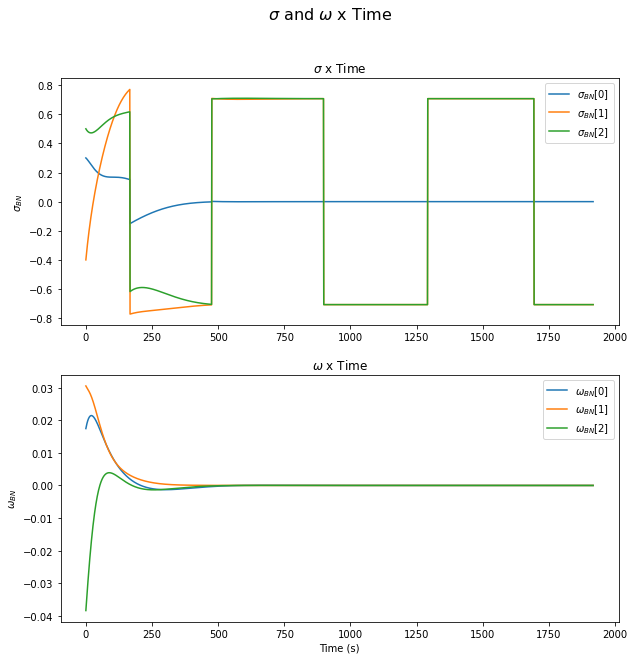

In [52]:
f_Rs = lambda t, X_Rs: X_dot(t, X_Rs, task=8)

x0_Rs = np.concatenate((sigma_BN, w_BN_B))
t0_Rs = 0
tf_Rs = list_changes[0]

dt = 1

x_Rs, t_Rs = RK4(f_Rs, x0_Rs, t0_Rs, tf_Rs, dt)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.plot(t_Rs, x_Rs[0][:], label='$\sigma_{BN}$[0]')
ax1.plot(t_Rs, x_Rs[1][:], label='$\sigma_{BN}$[1]')
ax1.plot(t_Rs, x_Rs[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')


ax2.plot(t_Rs, x_Rs[3][:], label='$\omega_{BN}$[0]')
ax2.plot(t_Rs, x_Rs[4][:], label='$\omega_{BN}$[1]')
ax2.plot(t_Rs, x_Rs[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [53]:
print(f'sigma(300s) = {x_Rs[0][int(300//dt)]} {x_Rs[1][int(300//dt)]} {x_Rs[2][int(300//dt)]}')


sigma(300s) = -0.04430505681471622 -0.7387613206031678 -0.6304173568057777


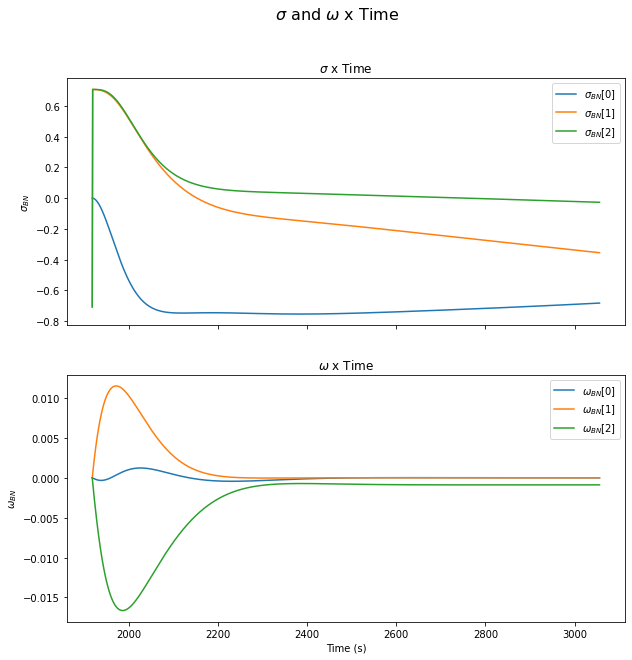

In [54]:
f_Rn = lambda t, X_Rn: X_dot(t, X_Rn, task=9)

x0_Rn = np.concatenate((sigma_BN, w_BN_B))
for i in range(6):
    x0_Rn[i] = x_Rs[i][-1]
t0_Rn = list_changes[0]
tf_Rn = list_changes[1]
dt = 1

x_Rn, t_Rn = RK4(f_Rn, x0_Rn, t0_Rn, tf_Rn, dt)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.plot(t_Rn, x_Rn[0][:], label='$\sigma_{BN}$[0]')
ax1.plot(t_Rn, x_Rn[1][:], label='$\sigma_{BN}$[1]')
ax1.plot(t_Rn, x_Rn[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.plot(t_Rn, x_Rn[3][:], label='$\omega_{BN}$[0]')
ax2.plot(t_Rn, x_Rn[4][:], label='$\omega_{BN}$[1]')
ax2.plot(t_Rn, x_Rn[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [55]:
print(f'sigma(2100s) = {x_Rn[0][int((2100-list_changes[0])/dt)]} {x_Rn[1][int((2100-list_changes[0])/dt)]} {x_Rn[2][int((2100-list_changes[0])/dt)]}')

sigma(2100s) = -0.7457011487076527 0.11463108205344132 0.1587569719735829


In [56]:
list_changes


[1918, 3057, 4067, 5469]

-0.6820335172206491
-0.3544755111555266
-0.026741101471685215
-6.149981498515061e-07
-1.000009434922008e-07
-0.0008848611050954349


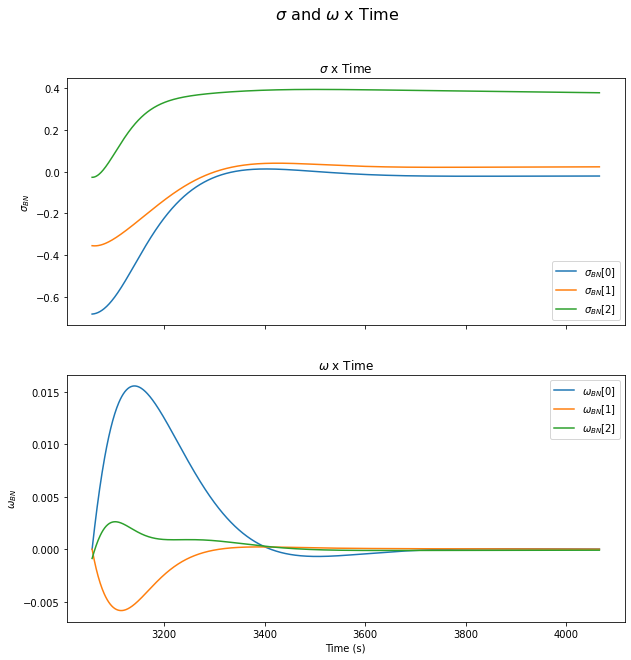

In [58]:
f_Rc = lambda t, X_Rc: X_dot(t, X_Rc, task=10)

x0_Rc = np.concatenate((sigma_BN, w_BN_B))
for i in range(6):
    x0_Rc[i] = x_Rn[i][-1]
    print(x_Rn[i][-1])
t0_Rc = list_changes[1]
tf_Rc = list_changes[2]
dt = 1

x_Rc, t_Rc = RK4(f_Rc, x0_Rc, t0_Rc, tf_Rc, dt)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.plot(t_Rc, x_Rc[0][:], label='$\sigma_{BN}$[0]')
ax1.plot(t_Rc, x_Rc[1][:], label='$\sigma_{BN}$[1]')
ax1.plot(t_Rc, x_Rc[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.plot(t_Rc, x_Rc[3][:], label='$\omega_{BN}$[0]')
ax2.plot(t_Rc, x_Rc[4][:], label='$\omega_{BN}$[1]')
ax2.plot(t_Rc, x_Rc[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [59]:
t_chg2 = 3400 
print(f'sigma(3400s) = {x_Rc[0][int((t_chg2-list_changes[1])/dt)]} {x_Rc[1][int((t_chg2-list_changes[1])/dt)]} {x_Rc[2][int((t_chg2-list_changes[1])/dt)]}')

sigma(3400s) = 0.013140275713223477 0.039735057657941344 0.3906425267265855


In [60]:
list_changes

[1918, 3057, 4067, 5469]

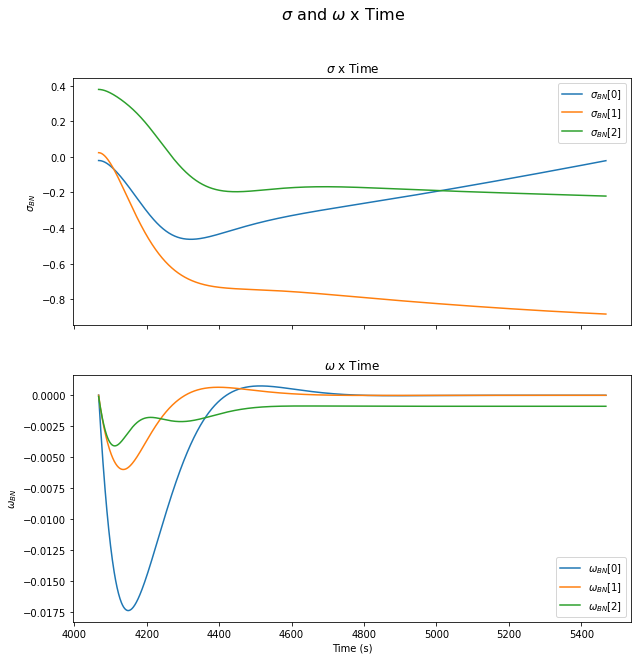

In [61]:
f_Rn_2 = lambda t, X_Rn_2: X_dot(t, X_Rn_2, task=9)

x0_Rn_2 = np.concatenate((sigma_BN, w_BN_B))
for i in range(6):
    x0_Rn_2[i] = x_Rc[i][-1]
t0_Rn_2 = list_changes[2]
tf_Rn_2 = list_changes[3]
dt = 1

x_Rn_2, t_Rn_2 = RK4(f_Rn_2, x0_Rn_2, t0_Rn_2, tf_Rn_2, dt)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.plot(t_Rn_2, x_Rn_2[0][:], label='$\sigma_{BN}$[0]')
ax1.plot(t_Rn_2, x_Rn_2[1][:], label='$\sigma_{BN}$[1]')
ax1.plot(t_Rn_2, x_Rn_2[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.plot(t_Rn_2, x_Rn_2[3][:], label='$\omega_{BN}$[0]')
ax2.plot(t_Rn_2, x_Rn_2[4][:], label='$\omega_{BN}$[1]')
ax2.plot(t_Rn_2, x_Rn_2[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [62]:
t_chg2 = 4400 
print(f'sigma(4400s) = {x_Rn_2[0][int((t_chg2-list_changes[2])/dt)]} {x_Rn_2[1][int((t_chg2-list_changes[2])/dt)]} {x_Rn_2[2][int((t_chg2-list_changes[2])/dt)]}')

sigma(4400s) = -0.43324310751578926 -0.7323087721926959 -0.1875591175612453


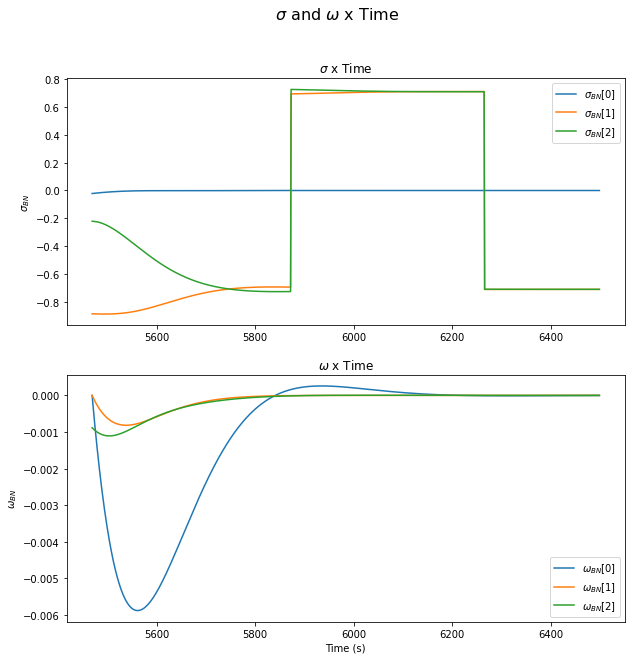

In [63]:
f_Rs_2 = lambda t, X_Rs_2: X_dot(t, X_Rs_2, task=8)

x0_Rs_2 = np.concatenate((sigma_BN, w_BN_B))
for i in range(6):
    x0_Rs_2[i] = x_Rn_2[i][-1]
t0_Rs_2 = list_changes[-1]
tf_Rs_2 = 6500
dt = 1

x_Rs_2, t_Rs_2 = RK4(f_Rs_2, x0_Rs_2, t0_Rs_2, tf_Rs_2, dt)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.plot(t_Rs_2, x_Rs_2[0][:], label='$\sigma_{BN}$[0]')
ax1.plot(t_Rs_2, x_Rs_2[1][:], label='$\sigma_{BN}$[1]')
ax1.plot(t_Rs_2, x_Rs_2[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.plot(t_Rs_2, x_Rs_2[3][:], label='$\omega_{BN}$[0]')
ax2.plot(t_Rs_2, x_Rs_2[4][:], label='$\omega_{BN}$[1]')
ax2.plot(t_Rs_2, x_Rs_2[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [64]:
t_chg2 = 5600
print(f'sigma(5600s) = {x_Rs_2[0][int((t_chg2-list_changes[-1])/dt)]} {x_Rs_2[1][int((t_chg2-list_changes[-1])/dt)]} {x_Rs_2[2][int((t_chg2-list_changes[-1])/dt)]}')

sigma(5600s) = -0.0012864139088247387 -0.8261093421593287 -0.503949218496923
